In [16]:
## Library
from IPython.display import display
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
from datetime import datetime

In [3]:
## Load Data

transactions = pd.read_csv("../transactions.csv")
customers = pd.read_csv("../customers.csv")
products = pd.read_csv("../products.csv")

print("=== Data Loaded ===")
print(f"Transactions: {transactions.shape}")
print(f"Customers: {customers.shape}")
print(f"Products: {products.shape}\n")

=== Data Loaded ===
Transactions: (498, 5)
Customers: (100, 3)
Products: (50, 4)



In [4]:
## Ubah type data column timestamp pada transaction menjadi datetime
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], errors='coerce')

In [5]:
## Exclude quantity yang null pada column transaction
transactions = transactions.dropna()

In [6]:
## Merged Data
merged = (
    transactions.merge(customers, on="customer_id", how="left")
    .merge(products, on="product_id", how="left")
)

In [7]:
## Buat column price dan month
merged["total_price"] = merged["quantity"] * merged["price"]
merged["month"] = merged["timestamp"].dt.to_period("M").astype(str)

In [8]:
merged.sample(5)

,transaction_id,customer_id,product_id,timestamp,quantity,join_date,customer_location,product_name,product_category,price,total_price,month
467,TRX0470,CUST020,PROD008,2024-10-30 17:00:00,1.0,2023-08-18,Medan,Sepatu Lari,Olahraga,750000,750000.0,2024-10
285,TRX0288,CUST038,PROD007,2025-01-10 11:00:00,1.0,2024-05-19,Medan,Celana Jeans,Pakaian,450000,450000.0,2025-01
430,TRX0433,CUST033,PROD001,2024-06-02 13:00:00,1.0,2024-03-02,Jakarta,Laptop Pro 15,Elektronik,15000000,15000000.0,2024-06
370,TRX0373,CUST053,PROD033,2023-03-20 14:55:00,1.0,2023-03-15,Denpasar,Raket Badminton,Olahraga,450000,450000.0,2023-03
325,TRX0328,CUST021,PROD027,2023-11-08 17:10:00,1.0,2023-09-02,Jakarta,Webcam HD,Elektronik,450000,450000.0,2023-11


In [9]:
## Ingest to database

server = 'localhost'
database = 'ecommerce'
username = 'sa'               # user SQL Server
password = 'admin'  # password login SQL Server
table = 'analytic'

# Driver bawaan SQL Server (pastikan sudah terinstall ODBC)
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

In [10]:
merged.to_sql(
    name=table,
    con=engine,
    if_exists='replace',# bisa diganti 'append' kalau mau nambah data
    index=False
)

148

In [11]:
cek = """
SELECT COUNT(*) AS total_rows
FROM ecommerce.dbo.analytic
"""

df = pd.read_sql_query(cek, con=engine)
df.head()

,total_rows
0,496


In [12]:
## Cek produk terlaris
query_top_products = """
SELECT TOP 5 
    product_name, 
    SUM(total_price) AS total_pendapatan
FROM analytic
GROUP BY product_name
ORDER BY total_pendapatan DESC;
"""
top_products = pd.read_sql_query(query_top_products, con=engine)
display("=== Top 5 Produk Terlaris ===")
display(top_products)

'=== Top 5 Produk Terlaris ==='

,product_name,total_pendapatan
0,Laptop Pro 15,390000000.0
1,Smartphone X,238000000.0
2,Sepatu Lari,18750000.0
3,Mechanical Keyboard,14400000.0
4,Tablet 10 inch,13500000.0


In [13]:
## Top Pelanggan
query_top_customers = """
SELECT TOP 10
    customer_id, 
    customer_location, 
    SUM(total_price) AS total_spent
FROM analytic
GROUP BY customer_id, customer_location
ORDER BY total_spent DESC
"""
top_customers = pd.read_sql_query(query_top_customers, con=engine)
display("=== Top 10 Pelanggan Paling Berharga ===")
display(top_customers)

'=== Top 10 Pelanggan Paling Berharga ==='

,customer_id,customer_location,total_spent
0,CUST005,Jakarta,111600000.0
1,CUST033,Jakarta,90600000.0
2,CUST021,Jakarta,62500000.0
3,CUST001,Jakarta,56590000.0
4,CUST029,Jakarta,52200000.0
5,CUST041,Surabaya,51800000.0
6,CUST018,Jakarta,50200000.0
7,CUST037,Jakarta,31500000.0
8,CUST025,Jakarta,31300000.0
9,CUST071,Denpasar,30000000.0


In [14]:
## Trend Penjualan
query_monthly_trend = """
SELECT
    month,
    SUM(total_price) AS total_pendapatan
FROM analytic
GROUP BY month
ORDER BY month;
"""
monthly_trend = pd.read_sql_query(query_monthly_trend, con=engine)
display("=== Tren Pendapatan Bulanan ===")
display(monthly_trend)

'=== Tren Pendapatan Bulanan ==='

,month,total_pendapatan
0,2023-01,24500000.0
1,2023-02,33380000.0
2,2023-03,53080000.0
3,2023-04,4930000.0
4,2023-05,7630000.0
5,2023-06,10620000.0
6,2023-07,14760000.0
7,2023-08,39200000.0
8,2023-09,19660000.0
9,2023-10,22470000.0


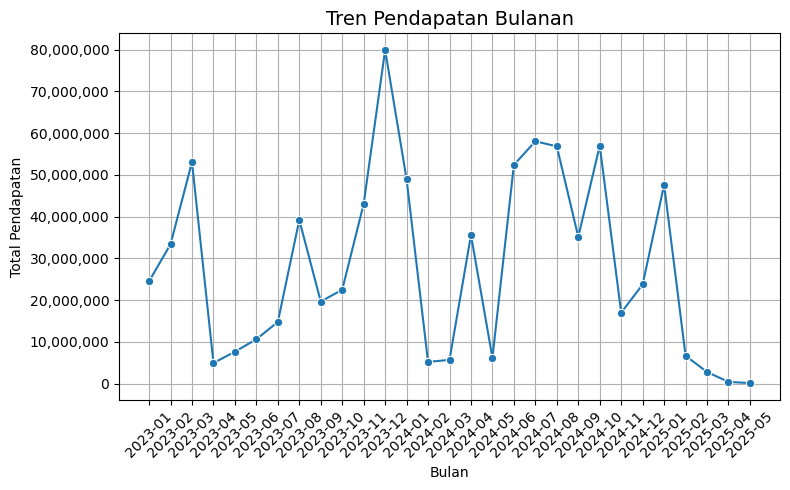

In [17]:
## Visualisasi
plt.figure(figsize=(8,5))
sns.lineplot(data=monthly_trend, x="month", y="total_pendapatan", marker="o")
plt.title("Tren Pendapatan Bulanan", fontsize=14)
plt.xlabel("Bulan")
plt.ylabel("Total Pendapatan")
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()